<a href="https://colab.research.google.com/github/Youngdeuk-Koo/KNLP/blob/main/OCR%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%B2%88%EC%97%AD%EA%B3%BC_%EC%9A%94%EC%95%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Tesseract 설치

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install tensorflow tensorflow_text

#2.Font 설치

In [2]:
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
import matplotlib as plt


fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'


font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# 그래프에 retina display 적용

%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정

plt.rc('font', family='NanumBarunGothic') 

In [3]:
import pytesseract
import shutil
import os
import random
try:
    from PIL import Image
except ImportError:
    import Image
import re
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw
import statistics

#3.이미지 가져오기

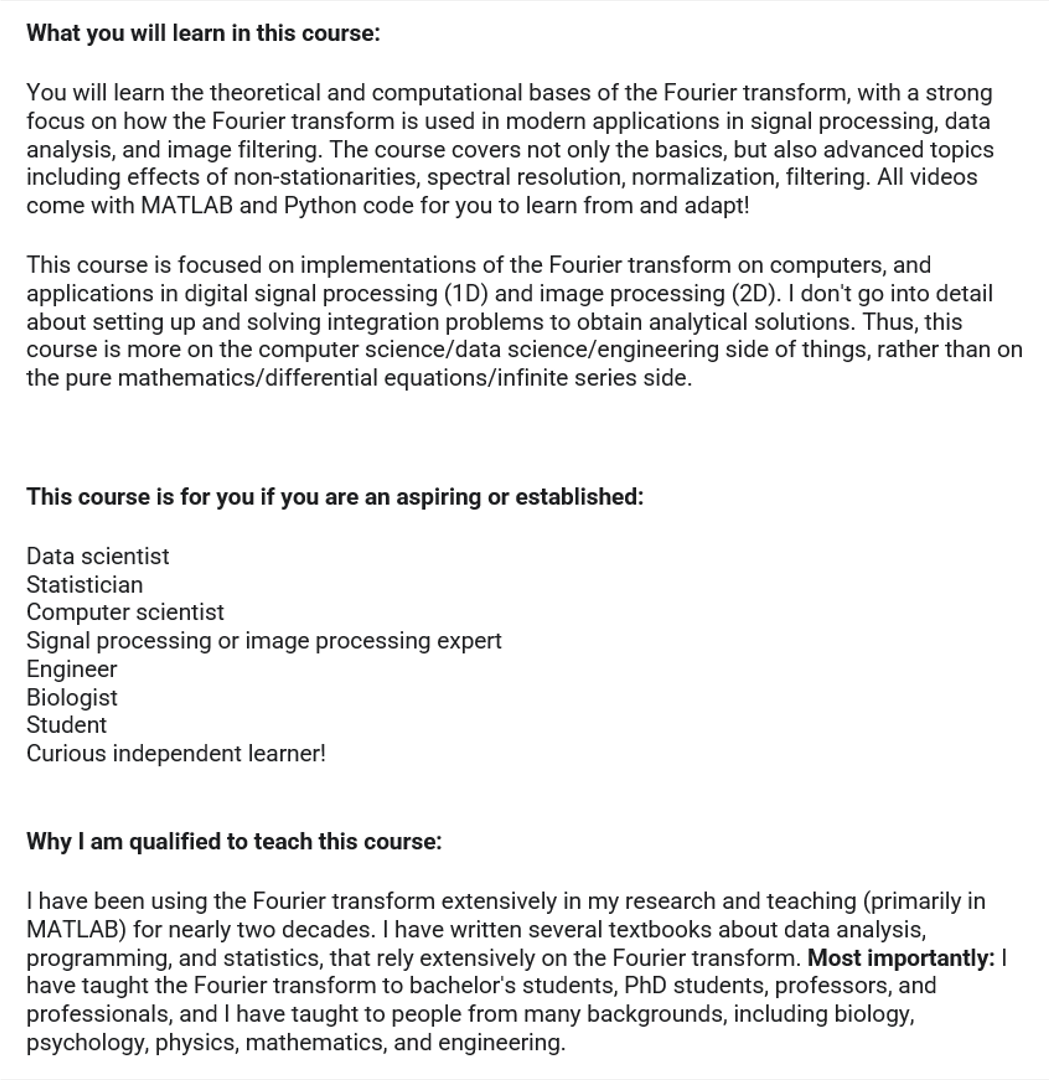

In [8]:
import PIL

book = PIL.Image.open('/content/drive/MyDrive/AI_Study/NLP/DATA/번역 이미지/t3.png')
book

#4.이미지 읽은후 Color 추출

In [56]:
src = cv2.imread('/content/drive/MyDrive/AI_Study/NLP/DATA/번역 이미지/t3.png')

pix_color = src[0, 0]
color = pix_color.tolist()
print('Color :', color)

Color : [248, 248, 248]


#5.OCR로 텍스트 추출 후 전처리

In [10]:
ori_text = pytesseract.image_to_string(src, lang='eng')
ori_text = ori_text.replace('In\n\n', 'In ')
ori_text = ori_text.replace('\n\n', '¾')
ori_text = ori_text.replace('\n', ' ')
ori_text = ori_text.replace('|', 'I')
ori_text = re.sub('[-=+#/\:;^$@*\’"“”※&ㆍ_『』\\‘|\(\)\[\]\<\>`\'"…》㎝「」]','', ori_text)
ori_text = ori_text.split('¾')

print(ori_text) # 영어 본문
print('문장 길이 :', sum([len(w) for w in ori_text]))

['What you will learn in this course', 'You will learn the theoretical and computational bases of the Fourier transform, with a strong focus on how the Fourier transform is used in modern applications in signal processing, data analysis, and image filtering. The course covers not only the basics, but also advanced topics including effects of nonstationarities, spectral resolution, normalization, filtering. All videos come with MATLAB and Python code for you to learn from and adapt!', 'This course is focused on implementations of the Fourier transform on computers, and applications in digital signal processing 1D and image processing 2D. I dont go into detail about setting up and solving integration problems to obtain analytical solutions. Thus, this course is more on the computer sciencedata scienceengineering side of things, rather than on the pure mathematicsdifferential equationsinfinite series side.', 'This course is for you if you are an aspiring or established', 'Data scientist',

#6.추출한 텍스트의 Font 크기 추출 및 가장 많이 나온 폰트로 전체 폰트 지정

In [57]:
data = pytesseract.image_to_data(src)

height_list = [val.split()[9] for idx, val in enumerate(data.splitlines()) if idx != 0 if len(val.split()) == 12]
font_size = int(statistics.mode(height_list))
print('폰트 크기 :', font_size)

폰트 크기 : 18


#7.추출한 텍스트의 문단(나눠지는 문장)별 시작 X좌표와 Y좌표 추출

In [12]:
x_min = min([int(val.split()[6]) for idx, val in enumerate(data.splitlines()) if idx != 0 if len(val.split()) == 12])
x_max = max([int(val.split()[6]) + int(val.split()[8]) for idx, val in enumerate(data.splitlines()) if idx != 0 if len(val.split()) == 12])
y_min = min([int(val.split()[7]) for idx, val in enumerate(data.splitlines()) if idx != 0 if len(val.split()) == 12])
y_max = max([int(val.split()[7]) + int(val.split()[9]) for idx, val in enumerate(data.splitlines()) if idx != 0 if len(val.split()) == 12])

print('문단의 가장 왼쪽 좌표 :', x_min)
print('문단의 가장 오른쪽 좌표 :', x_max)
print('문단의 가장 위쪽 좌표 :', y_min)
print('문단의 가장 아래쪽 좌표 :', y_max)

문단의 가장 왼쪽 좌표 : 26
문단의 가장 오른쪽 좌표 : 1022
문단의 가장 위쪽 좌표 : 23
문단의 가장 아래쪽 좌표 : 1055


#8.추출된 좌표를 기준으로 원래 배경색으로 Rectangle하여 원본 텍스트 지우기

In [ ]:
cv2.rectangle(src, (x_min-10, y_min-10), (x_max+10, y_max+10), color, -1)

#9.문단이 시작되는 텍스트의 X와 Y 좌표 추출

In [14]:
para_sep = 0
para_x, para_y = [], []

for x, b in enumerate(data.splitlines()):
    if x != 0:
        b = b.split()
        if len(b) == 11:
            para_sep += 1
            
        else:
            if para_sep < 2:
                para_sep = 0
                
            else:
                para_x.append(b[6]) # 문단 시작 x 좌표
                para_y.append(b[7]) # 문단 시작 y 좌표
                para_sep = 0
                
print('문단의 시작 x 좌표 :', para_x)
print('문단의 시작 y 좌표 :', para_y)

문단의 시작 x 좌표 : ['27', '26', '27', '26', '28', '27', '27', '27', '28', '27', '27', '27', '28']
문단의 시작 y 좌표 : ['23', '83', '255', '487', '547', '575', '602', '631', '688', '715', '744', '832', '891']


#10.번역모델

1.   파파고 API
2.   T5 Large 모델
3.   번역된 텍스트



###10-1. 파파고 API

In [11]:
# import os
# import sys
# import urllib.request


# # client_id = "4PUwE8MQTyF9CKWaJvCK" # 구영득 얼마 안남음
# # client_secret = "uJow0P5yp3"       # 구영득 얼마 안남음

# # client_id = "2feZ9K77LvoVWsw9mWkG" # 박훈일
# # client_secret = "ZAQ20Si1C"         # 박훈일

# client_id = "j0tkqzYjt5cizB_jUzBK" # 이우찬
# client_secret = "OPPfQRAN1L"        # 이우찬


# data = "source=en&target=ko&text="
# url = "https://openapi.naver.com/v1/papago/n2mt"

# class papago_en_ko(object):
#     def __init__(self, client_id, client_secret, data, url):
#         self.client_id = client_id
#         self.client_secret = client_secret
#         self.data = data
#         self.url = url
    
#     def __call__(self, sentence):
#         encText = urllib.parse.quote(sentence)
#         enc_data = self.data + encText
#         request = urllib.request.Request(self.url)
#         request.add_header("X-Naver-Client-Id",self.client_id)
#         request.add_header("X-Naver-Client-Secret",self.client_secret)
#         response = urllib.request.urlopen(request, data=enc_data.encode("utf-8"))
#         rescode = response.getcode()
#         if(rescode==200):
#             response_body = response.read()
#             result = response_body.decode('utf-8')
#             result_list = result.split(":")
#             translate_text = result_list[5]
#             translate_text = str(translate_text)
#             text_len = len(translate_text)
#             text = translate_text[1:text_len-14]

#             return text

#         else:
#             print("Error Code:" + rescode)

# translate = papago_en_ko(client_id, client_secret, data, url)

# kor_translate_text = [translate(ori_text[w]) for w in range(len(ori_text))]
# print('파파고 APi 번역 Text :', kor_translate_text)

###10-2. T5 Large 모델

In [15]:
import tarfile
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_text

path = '/content/drive/MyDrive/AI_Study/NLP/DATA/t5-model/t5_large.tar.gz'
_PATH = './translate_large_model'
tar_gz_file = tarfile.open(path)
tar_gz_file.extractall(path=_PATH)
tar_gz_file.close()

class translator(object):
    def __init__(self, load_model):
        self.load_model = load_model

    def __call__(self, text):
        x = tf.constant([text])
        result = self.load_model(x)
        translate = [out.decode('utf-8') for out in result['outputs'].numpy()]
        translate = ''.join(translate)

        return translate


model_path = "/content/translate_large_model/downstream_exported/t5.1.1.large.gin.ke.ke_v100_span_corruption.ke_t5_ko_translation_proportional"
loaded = tf.saved_model.load(model_path)
infer = loaded.signatures["serving_default"] #딕셔너리로 반환

translate = translator(infer)

kor_translate_text = [translate(ori_text[w]) for w in range(len(ori_text))]

print()
print('T5 모델 번역 Text :', kor_translate_text)


T5 모델 번역 텍스트 : ['이 강의에서 무슨 것을 배우게 되나 이 과정이 여러분들에게 무엇을 가르쳐 주는가에 대해 다시 배웠습니다 .', '그 4레이지 변형의 기초와 기하급수적인 이론적 배경의 Fourier 변형을 학습하면서 , 이 과정이 단순히 기본 이론만 가르치는 게 아니라 , 어떻게 이 4레이지 변형이 현대적인 신호 분석 및 데이터 분석 및 이미지 필터링에 사용되는지 집중적으로 학습할 수 있을지 확인해 볼 겁니다 . 모든 강의는 기본만 가르치는 게 아니라도 응용 가능하며 , MATLAB와 파이톤 언어를 사용하면 됩니다 .', '그 때문에 저는 Fourier 변형을 컴퓨터 환경에 적용시키는데 중점을 두고 있으며 1차원 디지털 신호 처리와 2차원 이미지 처리에서 응용을 하기보다는 복잡한 계산 문제를 설정하고 해결하는 것에 대해서는 자세히 설명하지 않습니다 . 이러한 과정을 수학적으로 잘 이해하기 위해서는 여러 조건에 대한 생각이 필요하기 때문이죠 . 그래서 이 과정은 엄밀히 말해 컴퓨터 공학과 자료 과학공학에 관한 것이고 수학 수학이 아닌 다른 분야의 이론들을 다루는 곳 이지요 .', '그 수업은 여러분을 위해 특별히 만들었는데 여러분이 원하고 능력있는 , 능력있는 사람 입니다 .', '그 당시 데이터 과학자는', '그 옆에는 통계학자가 Statistician 옆에', '그 분야의 컴퓨터 전문가는 다음과 같다 .', "그 분야의 전문가죠 . 신호 처리 전문가 또는 이미지 처리 전문가 ( Engineer )' 라고도 부르죠 .", '그 외 전문 병리생물학자 ,', '그 딸은', '그 어느 곳에서도 , 스스로를 제어하는 자율적인 학습자가 되세요 !', '그 과목을 가르칠 자격이 있는지에 대해서입니다 .', '그렉트 변형을 연구에서 열심히 사용했고 , MATLAB를 주로 가르쳤습니다 . 저는 자료 분석 , 프로그래밍 , 통계에 관한 여러 교재를 썼는데 , 그렉트 변형에 대한 게 굉장히 많습니다 . 가장 중요한 것은 , 학사 과정 학생들 , 박사과정 학생들 ,

###10-3.번역된 텍스트

In [217]:
kor_translate_text = ['본 코스에서 배울 내용', '신호 처리, 데이터 분석 및 이미지 필터링에서 현대 응용 분야에서 푸리에 변환이 어떻게 사용되는지에 초점을 맞춰 푸리에 변환의 이론적 및 계산 기반을 학습합니다. 이 과정에서는 기본 사항뿐만 아니라 비정상 효과, 스펙트럼 분해능, 정규화, 필터링을 포함한 고급 주제도 다룹니다. 모든 비디오에는 MATLAB 및 Python 코드가 함께 제공되므로 배우고 적응할 수 있습니다!', '이 과정은 컴퓨터에서의 푸리에 변환의 구현과 디지털 신호 처리 1D 및 이미지 처리 2D에서의 응용에 초점을 맞춥니다. 저는 분석적인 해결책을 얻기 위해 통합 문제를 설정하고 해결하는 것에 대해 자세히 설명하지 않습니다. 따라서, 이 과정은 순수 수학 미분 방정식 무한 급수 측면보다는 컴퓨터 과학 공학 측면에 더 가깝다.', '이 과정은 당신이 포부가 있거나 이미 확립된 경우 당신을 위한 것입니다.', '데이터 사이언티스트', '통계학자', '컴퓨터 과학자', '신호 처리 또는 이미지 처리 전문가 엔지니어', '생물학자', '학생', '호기심 많은 독자 학습자체 학습자 여러분!', '내가 이 과정을 가르칠 자격이 있는 이유', '저는 거의 20년 동안 주로 MATLAB에서 푸리에 변환을 연구 및 강의에 광범위하게 사용해 왔습니다. 저는 푸리에 변환에 광범위하게 의존하는 데이터 분석, 프로그래밍, 통계에 대한 여러 교재를 썼습니다. 가장 중요한 것은 푸리에 변환을 학사, 박사과정 학생, 교수, 전문가로 가르쳤고 생물학, 심리학, 물리학, 수학, 공학 등 다양한 배경의 사람들에게 가르쳤습니다.']
# kor_translate_text = ['킨들과 같은 디지털 독서 장치는 독자에게 제공되는 운동감각 및 촉각 피드백에 관해 종이책과 다르지만, 독서에서 이러한 기능의 역할은 경험적으로 연구된 적이 거의 없다. 이 실험은 킨들 DX와 인쇄물에서 긴 텍스트를 읽는 것을 비교합니다. 24세의 참가자 50명은 킨들이나 인쇄물 포켓북에서 28페이지 길이의 미스터리 스토리를 읽었고 다양한 수준의 독해력, 기억력, 본문의 사건들을 찾아내는 능력, 이야기의 줄거리를 재구성하는 여러 가지 테스트를 완료했다. 결과는 대부분의 테스트에서 피험자들이 읽기 매체가 무엇이든 동일하게 수행했다는 것을 보여주었다. 그러나 연대기와 일시성에 관한 측정에서는 인쇄물 포켓북에서 읽은 사람이 킨들로 읽었던 사람보다 더 잘했다. 기본적으로 이해력은 두 매체와 비슷하지만, 운동학적 피드백이 킨들에서는 덜 유익하기 때문에 독자들은 텍스트의 공간, 즉 이야기의 일시성에서 사건을 찾는 데 효율적이지 못했다. 우리는 텍스트의 정확한 공간적 표현과 결과적으로 이야기의 일관된 시간적 구성을 얻기 위해 독자들이 책의 조작에 의해 제공되는 감각 운동 단서에 의존할 것을 제안한다. 전반적으로, 서구 세계에서 독서는 점점 더 디지털화되고 있다. 킨들, 태블릿, 아이패드와 같은 휴대용 디지털 기기의 인기로 인해 롱폼 문어 읽기 또한 인쇄본보다는 스크린이 되고 있다. 이러한 전환은 내러티브, 문학 독서의 인지적, 정서적 측면에 대한 화면 디스플레이와 논문과 같은 기질적 어포던스의 역할과 관련된 많은 연구 질문을 불러온다. 주목할 만한 방법으로, 종이에서 화면으로의 이동은 독서가 인간공학 상호작용의 사례라는 것을 명백하게 만든다. 담화 처리의 보다 일반적으로 다루어지는 지각적, 인지적 구성 요소 외에도, 독서는 전형적으로 인쇄 포켓북, 전자책 또는 태블릿과 같은 장치와 수동적인 참여를 수반한다. 장치마다 사용자 인터페이스와 재료의 수용성이 다르며 인쇄 책자의 종이는 화면에 표시되는 텍스트와 다른 감각 운동 우발성을 제공한다. 인쇄된 텍스트는 물리적이고 접선적으로 매체와 인접한 반면, 디지털화된 텍스트는 매체와 물리적으로 분리될 수 있다. 이것은 디지털 장치가 많은 수의 텍스트와 다른 콘텐츠를 저장할 수 있게 한다. 그러나, 우리는 그러한 겉보기에는 미묘한 차이가 독서의 인지적, 경험적 애스핏과 상호작용할 수 있는 방법에 대해서는 거의 알지 못한다. 이론적인 일크의 독서 학자들은 어떻게 독서가 일반적으로 인정된 후각보다 더 다감각적인지 강조해 왔고, 시력은 독서에 있어서 가장 중요한 감각이라고 말한다. 그러나, 접촉은 아마도 가장 중요한 것일지도 모른다. 손에서 느껴지는 느낌, 종이의 냄새, 촉각적인 즐거움 화면을 조작하는 것은 읽는 습관을 강화하고 심화시킨다. 그리스 합티코스에서 온 광범위한 개념화, 촉각은 촉각을 의미한다. 따라서 수동 피부 촉각과 능동 자가수용 운동 감각 과정을 모두 포함한다. 연구 문헌에서, 햅틱, 힘 피드백, 운동 감각과 같은 용어들은 종종 번갈아 사용된다.']

#11.한글 폰트 크기 재조정

In [26]:
print('조정전 영어 폰트 크기 :', font_size)

ori_text_len = sum([len(w) for w in ori_text])
tra_text_len = sum([len(w) for w in kor_translate_text])
print('원본 테스트 총 길이 :', ori_text_len)
print('번역 테스트 총 길이 :', tra_text_len)

text_level = ori_text_len - tra_text_len
font_per = text_level / ori_text_len
print(f'조정할 폰트 크기 백분율 : {font_per:.2f}')

re_font = int((font_size + (font_size * font_per)) -1)
print('조정된 한글 폰트 크기 :', re_font)

조정전 영어 폰트 크기 : 18
원본 테스트 총 길이 : 1644
번역 테스트 총 길이 : 1025
조정할 폰트 크기 백분율 : 0.38
조정된 한글 폰트 크기 : 23


#12.각 문단이 들어갈 공간 넓이 계산

In [33]:
src_h, src_w, _ = src.shape

para_w = [src_w - int(para_x[i]) * 2 for i in range(len(kor_translate_text))]

print('이미지 문단 넓이 :', para_w)

이미지 문단 넓이 : [995, 997, 995, 997, 993, 995, 995, 995, 993, 995, 995, 995, 993]


#13.문단 넓이에 맞게 줄바꿈('\n')기호를 넣어주는 알고리즘

In [42]:
font_cnt = 0
kor_puttext = []
for i in range(len(kor_translate_text)):
    kor_puttext.append([])

    font_cnt = 0    
    for w in kor_translate_text[i]:
        if w == ' ':
            font_cnt += 5
            
        else:
            font_cnt += re_font-2  # 한글 폰트크기
            
        if font_cnt >= para_w[i]:
            w += '\n'
            font_cnt = 0
            
        kor_puttext[-1].append(w)

print('Put_text를 위한 줄바꿈 처리 :')        
print(kor_puttext)

Put_text를 위한 줄바꿈 처리 :
[['이', ' ', '강', '의', '에', '서', ' ', '무', '슨', ' ', '것', '을', ' ', '배', '우', '게', ' ', '되', '나', ' ', '이', ' ', '과', '정', '이', ' ', '여', '러', '분', '들', '에', '게', ' ', '무', '엇', '을', ' ', '가', '르', '쳐', ' ', '주', '는', '가', '에', ' ', '대', '해', ' ', '다', '시', ' ', '배', '웠', '습', '니', '다', ' ', '.\n'], ['그', ' ', '4', '레', '이', '지', ' ', '변', '형', '의', ' ', '기', '초', '와', ' ', '기', '하', '급', '수', '적', '인', ' ', '이', '론', '적', ' ', '배', '경', '의', ' ', 'F', 'o', 'u', 'r', 'i', 'e', 'r', ' ', '변', '형', '을', ' ', '학', '습', '하', '면', '서', ' ', ',', ' ', '이', ' ', '과', '정', '이', ' ', '단', '순\n', '히', ' ', '기', '본', ' ', '이', '론', '만', ' ', '가', '르', '치', '는', ' ', '게', ' ', '아', '니', '라', ' ', ',', ' ', '어', '떻', '게', ' ', '이', ' ', '4', '레', '이', '지', ' ', '변', '형', '이', ' ', '현', '대', '적', '인', ' ', '신', '호', ' ', '분', '석', ' ', '및', ' ', '데', '이', '터', ' ', '분', '석', ' ', '및', ' ', '이', '미', '지\n', ' ', '필', '터', '링', '에', ' ', '사', '용', '되', '는', '지', ' ', '집', '중', '적'

#14.줄바꿈 기호 전처리 과정

In [43]:
kor_translate_text_update = []
for i in range(len(kor_translate_text)):
    result = ''.join(s for s in kor_puttext[i])
    result = re.sub("\n", "\n", result)
    result = re.sub("\n ", "\n", result)
    result = re.sub("\n\n\n", "\n", result)
    kor_translate_text_update.append(result)

print('부족한 줄바꿈 처리 보강 :') 
print(kor_translate_text_update)

부족한 줄바꿈 처리 보강 :
['이 강의에서 무슨 것을 배우게 되나 이 과정이 여러분들에게 무엇을 가르쳐 주는가에 대해 다시 배웠습니다 .\n', '그 4레이지 변형의 기초와 기하급수적인 이론적 배경의 Fourier 변형을 학습하면서 , 이 과정이 단순\n히 기본 이론만 가르치는 게 아니라 , 어떻게 이 4레이지 변형이 현대적인 신호 분석 및 데이터 분석 및 이미지\n필터링에 사용되는지 집중적으로 학습할 수 있을지 확인해 볼 겁니다 . 모든 강의는 기본만 가르치는 게 아니\n라도 응용 가능하며 , MATLAB와 파이톤 언어를 사용하면 됩니다 .', '그 때문에 저는 Fourier 변형을 컴퓨터 환경에 적용시키는데 중점을 두고 있으며 1차원 디지털 신호 처\n리와 2차원 이미지 처리에서 응용을 하기보다는 복잡한 계산 문제를 설정하고 해결하는 것에 대해서는 자세히\n설명하지 않습니다 . 이러한 과정을 수학적으로 잘 이해하기 위해서는 여러 조건에 대한 생각이 필요하기 때\n문이죠 . 그래서 이 과정은 엄밀히 말해 컴퓨터 공학과 자료 과학공학에 관한 것이고 수학 수학이 아닌 다른 분\n야의 이론들을 다루는 곳 이지요 .', '그 수업은 여러분을 위해 특별히 만들었는데 여러분이 원하고 능력있는 , 능력있는 사람 입니다 .', '그 당시 데이터 과학자는', '그 옆에는 통계학자가 Statistician 옆에', '그 분야의 컴퓨터 전문가는 다음과 같다 .', "그 분야의 전문가죠 . 신호 처리 전문가 또는 이미지 처리 전문가 ( Engineer )' 라고도 부르죠 .\n", '그 외 전문 병리생물학자 ,', '그 딸은', '그 어느 곳에서도 , 스스로를 제어하는 자율적인 학습자가 되세요 !', '그 과목을 가르칠 자격이 있는지에 대해서입니다 .', '그렉트 변형을 연구에서 열심히 사용했고 , MATLAB를 주로 가르쳤습니다 . 저는 자료 분석 , 프로그\n래밍 , 통계에 관한 여러 교재를 썼는데 , 그렉트 변형에 대한 게 굉장히 많습니다 . 가장 중요한 것은 , 학\n사

#15.번역된 Text Draw

In [44]:
src1 = Image.fromarray(src)
draw = ImageDraw.Draw(src1)

font = ImageFont.truetype("NanumBarunGothic.ttf", re_font)

for i in range(len(kor_translate_text_update)):
    draw.text((int(para_x[i]), int(para_y[i])), kor_translate_text_update[i], spacing=5, font=font, fill=(0, 0, 0))

src_f = np.array(src1)

#16.출력

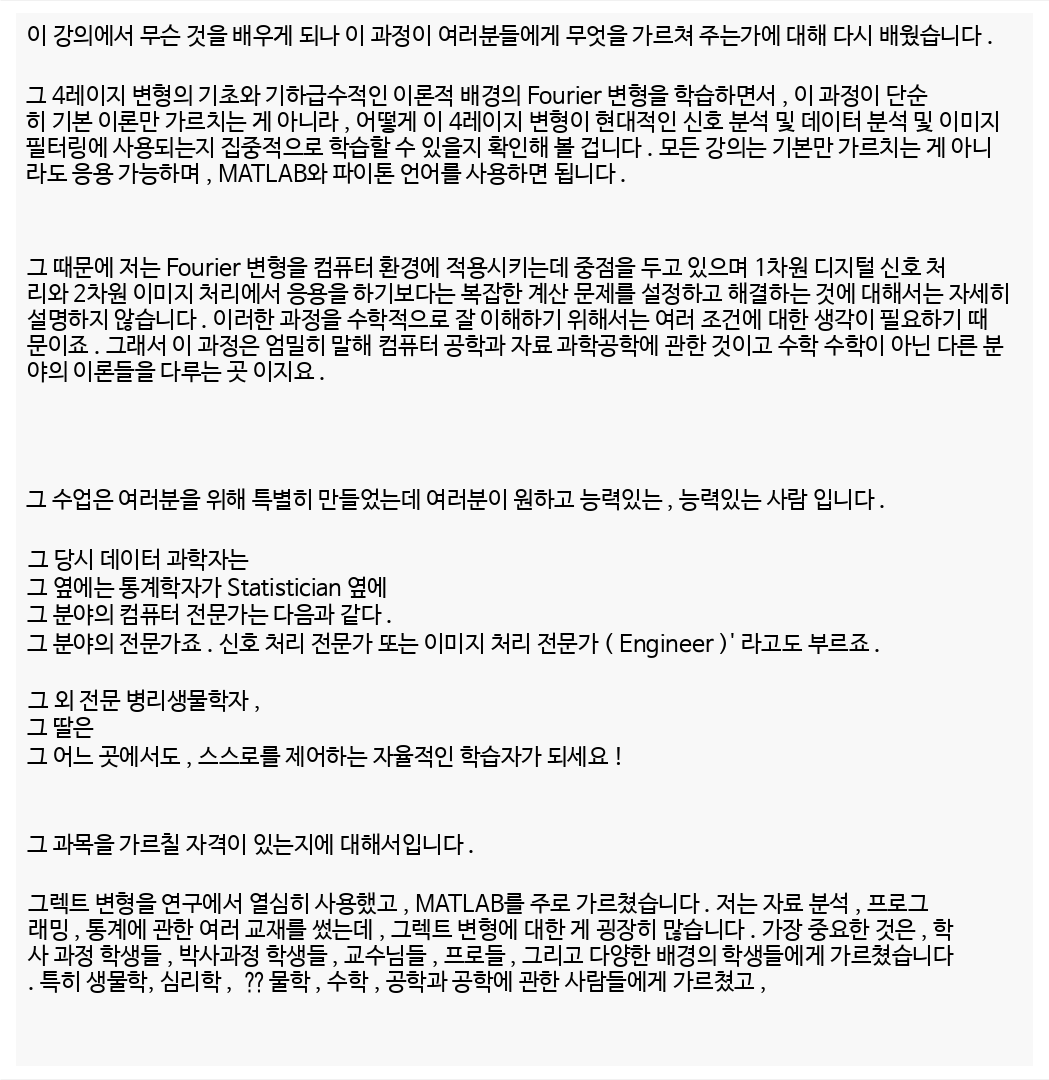

In [45]:
from google.colab.patches import cv2_imshow

cv2_imshow(src_f)

#17.메캅 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [47]:
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np

#18.불용어 데이터 불러오기

In [48]:
with open('/content/drive/MyDrive/AI_Study/NLP/DATA/전처리용 DATA/custom_stopwords.txt', 'r', encoding='utf-8') as f :
    stopwords = f.read().splitlines()  

#19.불용어 제거 후 명사만 분류

In [49]:
class Mecab_sentence(object):

    def __init__(self): 
        self.stopwords = stopwords
        self.mecab = Mecab()

    def nouns(self, sentences):
        nouns = []
        for sen in sentences:
            if sen != ' ' :
                nouns.append(" ".join([noun for noun in self.mecab.nouns(str(sen)) 
                                  if noun not in self.stopwords and len(noun) > 1]))
        return nouns

#20.TF-IDF 및 카운트 벡터 추출

In [50]:
class G_matrix(object):

    def __init__(self):
        self.TF_IDF = TfidfVectorizer()
        self.cnt_vec = CountVectorizer()
  
    def sent_matrix(self, nouns):
        TF_IDF_MAT = self.TF_IDF.fit_transform(nouns).toarray()
        graph_sentence = np.dot(TF_IDF_MAT, TF_IDF_MAT.T)    # 용어 빈도와 역 문서 빈도와의 통계 곱
        return graph_sentence

    def word_matrix(self, nouns):
        CNT_VEC_MAT = normalize(self.cnt_vec.fit_transform(nouns).toarray().astype(float), axis=0)
        vocab = self.cnt_vec.vocabulary_
        return np.dot(CNT_VEC_MAT.T, CNT_VEC_MAT), {vocab[word] : word for word in vocab}

#21.연립방정식을 이용한 Rank 태그

In [51]:
class Rank(object):

    def get_ranks(self, graph, d=0.85):
        A = graph
        matrix_size = A.shape[0]           # sent_graph 의 행 길이만큼(706)   
        for idx in range(matrix_size):     # sent_graph 의 행 길이만큼의 인덱스(0 ~ 705) 
            A[idx, idx] = 0                  # sent_graph 의 왼쪽위 기준으로 대각선을 0으로 변경(706 x 706)
            link_sum = np.sum(A[:, idx])     # sent_graph 의 열 마다 모두 더한다
            if link_sum != 0 :               # sent_graph 의 열 마다 모두 더한 값이 0이 아닌 경우에
                A[:, idx] /= link_sum
            A[:, idx] *= -d
            A[idx, idx] = 1

        B = (1-d) * np.ones((matrix_size, 1)) 
        x = np.linalg.solve(A, B)          # 연립방정식 Ax = B
        return {idx : r[0] for idx, r in enumerate(x)}

#22.Rank를 기반으로 문장과 키워드 추출

In [52]:
class TextRank(object):

    def __init__(self, text):
     
        self.sentence = text
        self.sent_tokenize = Mecab_sentence()
        self.nouns = self.sent_tokenize.nouns(self.sentence)

        self.matrix = G_matrix()
        self.sent_graph = self.matrix.sent_matrix(self.nouns)
        self.word_graph, self.idx2word =  self.matrix.word_matrix(self.nouns)

        self.rank = Rank()
        self.sent_rank_idx = self.rank.get_ranks(self.sent_graph)
        self.sorted_sent_rank_idx = sorted(self.sent_rank_idx, key=lambda k: self.sent_rank_idx[k], reverse=True)

        self.word_rank_idx = self.rank.get_ranks(self.word_graph)
        self.word_sent_rank_idx = sorted(self.word_rank_idx, key=lambda k: self.word_rank_idx[k], reverse=True)

    def key_sentence(self, sentence_num=3):
        summary = []
        index = []
        for idx in self.sorted_sent_rank_idx[:sentence_num]:
            index.append(idx)

        index.sort()
        for idx in index:
            summary.append(self.sentence[idx])

    
        return [w for w in summary]

    def key_words(self, word_num=10):
        rank_idx = self.rank.get_ranks(self.word_graph)
        sorted_rank_idx = sorted(rank_idx, key=lambda k: rank_idx[k], reverse=True)
    
        keywords = []
        index=[]

        for idx in sorted_rank_idx[:word_num]:
            index.append(idx)
        #index.sort()
        for idx in index:
            keywords.append(self.idx2word[idx])
    
        return keywords

#23.번역된 문장 join으로 str후 .를 기준으로 문단 분류

In [53]:
kor_translate_text = ''.join(kor_translate_text)
kor_translate_text = kor_translate_text.replace('.', '¾')
kor_translate_text = kor_translate_text.split('¾')

#24.요약 출력

In [54]:
textrank = TextRank(kor_translate_text)

for idx, val in enumerate(textrank.key_sentence()) : 
    print(f'{idx+1}번째 핵심 문장 : {val}', '\n')

print('-' * 100, '\n')
print('핵심 키워드 :', textrank.key_words())

1번째 핵심 문장 : 그 4레이지 변형의 기초와 기하급수적인 이론적 배경의 Fourier 변형을 학습하면서 , 이 과정이 단순히 기본 이론만 가르치는 게 아니라 , 어떻게 이 4레이지 변형이 현대적인 신호 분석 및 데이터 분석 및 이미지 필터링에 사용되는지 집중적으로 학습할 수 있을지 확인해 볼 겁니다  

2번째 핵심 문장 :  그래서 이 과정은 엄밀히 말해 컴퓨터 공학과 자료 과학공학에 관한 것이고 수학 수학이 아닌 다른 분야의 이론들을 다루는 곳 이지요  

3번째 핵심 문장 :  신호 처리 전문가 또는 이미지 처리 전문가 ( Engineer )' 라고도 부르죠  

---------------------------------------------------------------------------------------------------- 

핵심 키워드 : ['변형', '학습', '과정', '이미지', '신호', '이론', '분석', '배경', '기본', '컴퓨터']
